#  IF Algorithm Analysis
It shows the problems of the _standard_ algorithm, using the __full__ training set.

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pandas as pd
from scipy import stats
from sklearn import metrics
from os.path import dirname, join as pjoin
from sklearn.ensemble import IsolationForest
from sklearn.ensemble._iforest import _average_path_length 
import seaborn as sns



def get_data(name):
    
    print('\n')
    # fix the data directory before starting
    filename = pjoin('..','Datasets','data',name)
    print(name)
    
    # load data stored in .mat files
    mat_contents = sio.loadmat(filename)

    X,y = mat_contents['X'],mat_contents['y']
    
    # dataset statistics
    n_data        = X.shape[0]
    n_features    = X.shape[1]
    n_anomalies   = sum(y.flatten())
    contamination = n_anomalies/n_data * 100
    
    return X,y

def measure(y_true, y_pred, plot = False):

    # apply metrics
    fpr, tpr, thresholds          = metrics.roc_curve(y_true, y_pred)
    auc                           = metrics.auc(fpr, tpr)
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    average_precision_score       = metrics.average_precision_score(y_true, y_pred)

    if plot == True:
        plot_prc(fpr, tpr,auc,recall,precision,average_precision_score) 
    else: 
        return average_precision_score

def plot_prc(fpr, tpr,auc,recall,precision,average_precision_score):

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=[5*2,5])

    def ax_plot(ax,x,y,xlabel,ylabel,title=''):
        ax.plot(x,y);ax.set_xlabel(xlabel),;ax.set_ylabel(ylabel)
        ax.set_title(title);ax.grid()

    ax_plot(ax1,fpr, tpr,'fpr', 'tpr',title="auc: {:.3f}".format(auc))
    ax_plot(ax2,recall,precision, 'recall','precision', title="average precision: {:.3f}".format(average_precision_score))

## Toy datasets
- single cluster
- double cluster 
- toroid

In [2]:
def single_cluster(seed):

    np.random.seed(seed)
    
    std = 0.1
    central_cluster = np.random.randn(1000,2)*std

    anomaly = (np.random.rand(50,2)-0.5)*2

    data  = np.vstack([central_cluster,anomaly])
    labels = np.linalg.norm(data,axis=1)>3*std

    plt.figure(figsize=[5,5])
    plt.scatter(data[:,0],data[:,1],c=1-labels,cmap='Set1')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    #plt.grid(True)
    
    plt.xticks([]);plt.yticks([])
    
    return data,labels

def double_cluster(seed):

    np.random.seed(seed)
    
    std = 0.1
    step = 0.4
    sx_cluster = np.random.randn(500,2)*std+step
    dx_cluster = np.random.randn(500,2)*std-step

    anomaly = (np.random.rand(25,2)-0.5)*2

    data  = np.vstack([sx_cluster,dx_cluster,anomaly])
    labels = (np.linalg.norm(data+step,axis=1)>std*3)&(np.linalg.norm(data-step,axis=1)>std*3)

    plt.figure(figsize=[5,5])
    plt.scatter(data[:,0],data[:,1],c=1-labels,cmap='Set1')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    #plt.grid(True)
    
    plt.xticks([]);plt.yticks([])
    
    return data,labels

def square_toroid(seed):

    np.random.seed(seed)
    
    std = 0.1
    central_cluster = np.random.uniform(-0.8,0.8,[1000,2])
    central_cluster = central_cluster[np.any(np.abs(central_cluster)>0.6,axis=1)]

    anomaly = np.random.uniform(-0.55,0.55,[100,2])

    data = np.vstack([central_cluster,anomaly])

    labels = np.hstack([np.zeros(central_cluster.shape[0]),np.ones(anomaly.shape[0])])


    plt.figure(figsize=[5,5])
    plt.scatter(data[:,0],data[:,1],c=1-labels,cmap='Set1')
    #plt.scatter(anomaly[:,0],anomaly[:,1])
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    #plt.grid(True)
    
    plt.xticks([]);plt.yticks([])
    
    return data,labels

def get_grid(n):
    
    x_grid,y_grid = np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n))
    data_grid = np.vstack([np.ravel(x_grid),np.ravel(y_grid)]).T
    
    return data_grid,x_grid,y_grid

Dataset load.

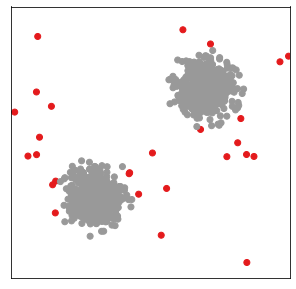

In [3]:
# dataset load

#data_train,labels_train = single_cluster()
data_train,labels_train = double_cluster(0)
#data_train,labels_train = square_toroid()

n = 25 ; data_grid,x_grid,y_grid = get_grid(n)

#data_train,labels_train = get_data('ionosphere')
#data_train,labels_train = get_data('speech')
#data_train,labels_train = get_data('mammography')

_Standard_ IF training.

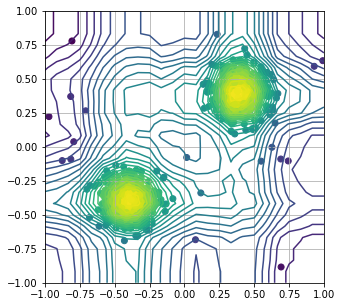

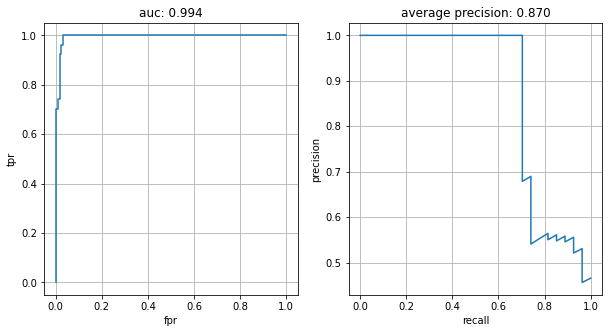

In [4]:
# unsupervised training

sk_IF       = IsolationForest(random_state=0).fit(data_train)

y_pred      = sk_IF.score_samples(data_train)
y_grid_pred = sk_IF.score_samples(data_grid)

# plot of the anomaly score
plt.figure(figsize=[5,5])
plt.scatter(data_train[:,0],data_train[:,1],c=y_pred)
plt.xlim([-1,1]);plt.ylim([-1,1]);plt.grid(True)
plt.contour(x_grid,y_grid,y_grid_pred.reshape(n,n),levels=25)

measure(labels_train,  -y_pred, plot=True) # MINUS SIGN

## Analysis

To get the tree depths for each sample point, we used a modified version of the original _sklearn_ function, that can be found here:
- https://github.com/scikit-learn/scikit-learn/blob/844b4be24/sklearn/ensemble/_iforest.py#L26

In [5]:
def compute_tree_anomaly_scores(forest,X):
    """
    Compute the score of each samples in X going through the extra trees.
    Parameters
    ----------
    X : array-like or sparse matrix
        Data matrix.
    subsample_features : bool
        Whether features should be subsampled.
    """
    n_samples = X.shape[0]

    depths = np.zeros(n_samples, order="f")
    
    collection_tree_anomaly_scores = []

    for tree in forest.estimators_:

        leaves_index   = tree.apply(X)
        node_indicator = tree.decision_path(X)
        n_samples_leaf = tree.tree_.n_node_samples[leaves_index]

        tree_anomaly_scores = (
            np.ravel(node_indicator.sum(axis=1))
            + _average_path_length(n_samples_leaf)
            - 1.0)
            
        depths += tree_anomaly_scores
        
        
        collection_tree_anomaly_scores.append(tree_anomaly_scores)
        
        
    denominator = len(forest.estimators_) * _average_path_length([forest.max_samples_])
    scores = 2 ** (
        # For a single training sample, denominator and depth are 0.
        # Therefore, we set the score manually to 1.
        -np.divide(
            depths, denominator, out=np.ones_like(depths), where=denominator != 0
        )
    )
    return scores,np.array(collection_tree_anomaly_scores)

Compute the anomaly scores.

True
Original forest average precision: 0.87


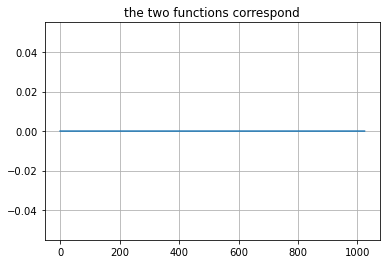

In [6]:
# compute the anomaly scores for each data

sklean_scores,tree_train = compute_tree_anomaly_scores(sk_IF,data_train)

# check 1
plt.plot(sklean_scores == y_pred)
plt.title('the two functions correspond');plt.grid()
# check 2
print(measure(labels_train,-y_pred) == measure(labels_train,-tree_train.mean(axis=0))) # MINUS SIGN
print("Original forest average precision: {:.3}".format(measure(labels_train,-tree_train.mean(axis=0)))) # MINUS SIGN

Compute the average precision for each tree.

In [7]:
# average precision for each tree
ap_tree_train = np.array([measure(labels_train, - __tree_train__) for __tree_train__ in tree_train]) ## MINUS SIGN

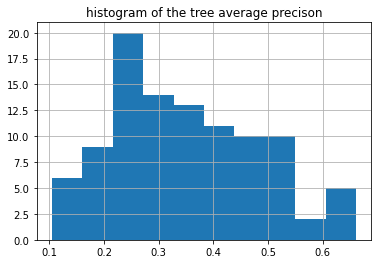

In [8]:
# histogram of average precisions of the trees
_ = plt.hist(ap_tree_train)
plt.title('histogram of the tree average precison');plt.grid(True)

### Best strategy
Compute the strategy named _best_

best  tree average precision: 0.661
worst tree average precision: 0.105


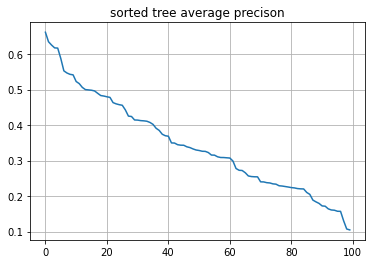

In [9]:
# learns the best tree order, according to the average precision score previously computed
learned_ordering      = np.argsort(ap_tree_train)[::-1]

# sorts the average precisions, using the learned ordering
# this step is not used in the algorithm, it is just a check
sorted_ap_tree_train = ap_tree_train[learned_ordering]

plt.plot(sorted_ap_tree_train)
plt.title('sorted tree average precison');plt.grid(True)

print("best  tree average precision: {:.3f}".format(sorted_ap_tree_train[0]))
print("worst tree average precision: {:.3f}".format(sorted_ap_tree_train[-1]))

Tree sorting and computation of forests anomaly scores 

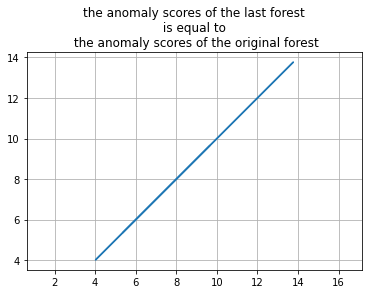

In [10]:
# orders the trees accoridng to the learned ordering
sorted_tree_train     = tree_train[learned_ordering]

# computes the anomaly scores for each forest
forest_train = (sorted_tree_train.cumsum(axis=0).T/np.arange(1,sorted_tree_train.shape[0]+1)).T

# check
plt.plot(forest_train[-1],tree_train.mean(axis=0));plt.grid(True)
plt.title('the anomaly scores of the last forest\n is equal to \n the anomaly scores of the original forest')
_=plt.axis('equal')

Computes the average precision for each forest.

first forest average precision (= best tree average precision): 		      0.661
last forest average precision (= original standard forest average precision): 	      0.870


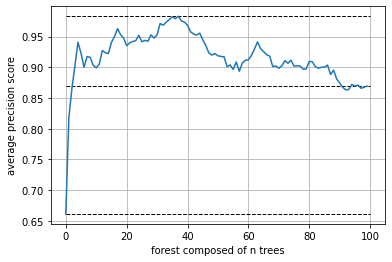

In [11]:
# average precision for each forest
ap_forest_train = np.array([measure(labels_train, - __forest__) for __forest__ in forest_train]) ## MINUS SIGN
    
plt.plot(ap_forest_train);plt.grid(True);plt.xlabel("forest composed of n trees");plt.ylabel("average precision score")

print("first forest average precision (= best tree average precision): \t\t {:10.3f}".format(ap_forest_train[0]))
print("last forest average precision (= original standard forest average precision): \t {:10.3f}".format(ap_forest_train[-1]))

plt.hlines(ap_forest_train[0],0,100,color='k',linestyle='--',linewidth=1)
plt.hlines(ap_forest_train[-1],0,100,color='k',linestyle='--',linewidth=1)
plt.hlines(ap_forest_train.max(),0,100,color='k',linestyle='--',linewidth=1)

# Functions

In [12]:
def study(data_train,labels_train):
    
    n_repetitions = 100
    
    sk_IF = train_test_measure(data_train,labels_train)
    
    ap_tree_train,tree_train = get_tree_collections(sk_IF,data_train,labels_train)
    
    plt.figure()
    _ = plt.hist(ap_tree_train)
    plt.title('histogram of the tree average precison');plt.grid(True)

    best  = get_forests('best', labels_train,ap_tree_train,tree_train)
    worst = get_forests('worst',labels_train,ap_tree_train,tree_train)
    mean_random,std_random = get_random_forests(labels_train,n_repetitions,ap_tree_train,tree_train)
    
    plt.figure()
    plt.plot(best, label='best')
    plt.plot(worst,label='worst')
    plt.xlabel("forest composed of $n$ trees");plt.ylabel("average precision score")
    
    x = np.hstack([np.arange(100),np.arange(100)[::-1]])
    y = np.hstack([mean_random+std_random,(mean_random-std_random)[::-1]])
    plt.plot(mean_random,color='green',linestyle='--',label='random')
    plt.fill(x,y,color='green',alpha=0.1)
    
    plt.grid(True);plt.legend()


    plt.hlines(best[0],     0,100,color='k',linestyle='--',linewidth=1)
    plt.hlines(best[-1],    0,100,color='k',linestyle='--',linewidth=1)
    plt.hlines(best.max(),  0,100,color='k',linestyle='--',linewidth=1)
    plt.hlines(worst[0],    0,100,color='k',linestyle='--',linewidth=1)
    plt.hlines(worst.min(), 0,100,color='k',linestyle='--',linewidth=1)

def train_test_measure(data,labels):
    
    sk_IF       = IsolationForest(random_state=0).fit(data)
    y_pred      = sk_IF.score_samples(data)

    measure(labels,  -y_pred, plot=True)
    
    return sk_IF

def get_tree_collections(sk_IF,data_train,labels_train):

    sklean_scores,tree_train = compute_tree_anomaly_scores(sk_IF,data_train)
    
    ap_tree_train            = np.array([measure(labels_train, - __tree_train__) for __tree_train__ in tree_train]) ## MINUS SIGN
    
    return ap_tree_train,tree_train

def get_forests(strategy,labels_train,ap_tree_train,tree_train):

    if strategy == 'best':
        order = -1
    elif strategy == 'worst':
        order = 1
        
    learned_ordering = np.argsort(ap_tree_train)[::order]

    sorted_tree_train = tree_train[learned_ordering]

    forest_train = (sorted_tree_train.cumsum(axis=0).T/np.arange(1,sorted_tree_train.shape[0]+1)).T
    
    ap_forest_train = np.array([measure(labels_train, - __forest__) for __forest__ in forest_train]) ## MINUS SIGN

    return ap_forest_train

def get_random_forests(labels_train,n_repetitions,ap_tree_train,tree_train):

    repetitions_ap_forest_train = []
    for r in range(n_repetitions):
        print("\r random repetition {:.0f}".format(r),end='')

        # random ordering
        learned_ordering = np.random.choice(np.arange(tree_train.shape[0]),tree_train.shape[0],replace=False)

        sorted_tree_train = tree_train[learned_ordering]

        forest_train = (sorted_tree_train.cumsum(axis=0).T/np.arange(1,sorted_tree_train.shape[0]+1)).T

        ap_forest_train = np.array([measure(labels_train, - __forest__) for __forest__ in forest_train]) ## MINUS SIGN

        repetitions_ap_forest_train.append(ap_forest_train)
    repetitions_ap_forest_train = np.array(repetitions_ap_forest_train)

    mean_random = repetitions_ap_forest_train.mean(axis=0)
    std_random  = repetitions_ap_forest_train.std(axis=0)
    
    return mean_random,std_random

 random repetition 99

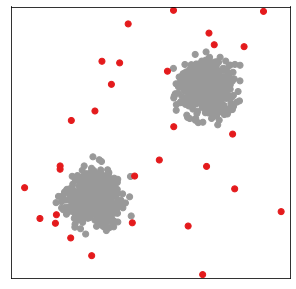

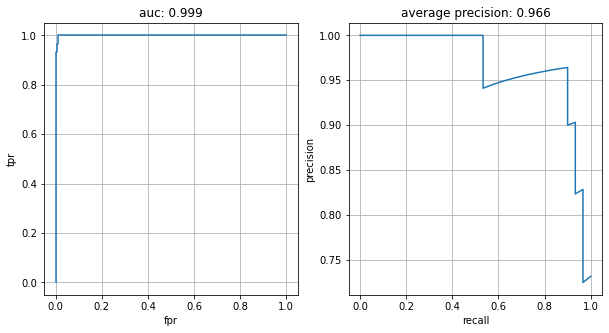

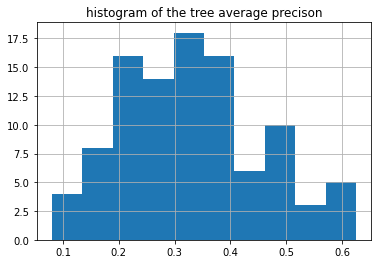

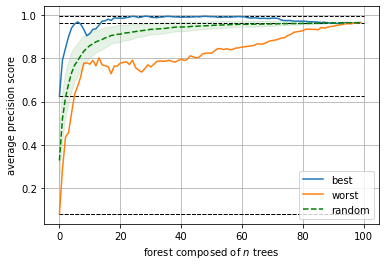

In [14]:
data,labels = double_cluster(None)
study(data,labels)

 random repetition 99

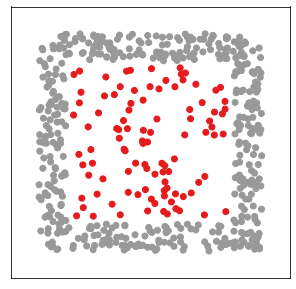

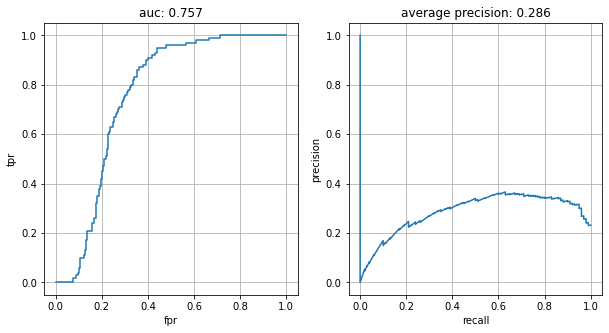

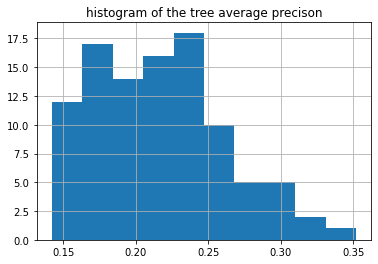

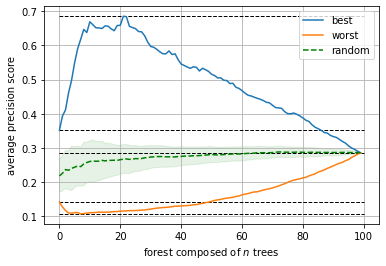

In [15]:
data,labels = square_toroid(None)
study(data,labels)